<a href="https://colab.research.google.com/github/MatthewAlvarez5/MsPacman-Atari-Domain/blob/main/Dueling_DDQN_MsPacman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN for MsPacman domain

In [ ]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.3 MB/s eta 0:00:00


In [ ]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/bank_heist.bin
Inst

# Install the Gym

In [ ]:
import ale_py
import gymnasium as gym

# Configure the model save drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
save_dir = "/content/drive/MyDrive/PUBLIC/Models"
os.makedirs(save_dir, exist_ok=True)

# Now Model

In [ ]:
from dataclasses import dataclass
import argparse
import time
from datetime import datetime
import numpy as np
import collections
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard.writer import SummaryWriter

In [ ]:
# Simply change these values to test the DQN with or without each extension
USE_DUELING = True;
USE_DDQN = True;

In [ ]:
#dqn_model
if not USE_DUELING:
  class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

In [ ]:
if(USE_DUELING):
  class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),              nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),              nn.ReLU(),
            nn.Flatten(),
        )
        feat_size = self.conv(torch.zeros(1, *input_shape)).size(-1)
        # Value stream
        self.value = nn.Sequential(nn.Linear(feat_size, 512), nn.ReLU(), nn.Linear(512, 1))
        # Advantage stream
        self.adv   = nn.Sequential(nn.Linear(feat_size, 512), nn.ReLU(), nn.Linear(512, n_actions))

    def forward(self, x):
        x = x.float() / 255.0
        f = self.conv(x)
        v = self.value(f)                         # [B, 1]
        a = self.adv(f)                           # [B, A]
        q = v + (a - a.mean(dim=1, keepdim=True)) # [B, A]
        return q


In [ ]:
#wrappers

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers


class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, n_steps=4, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    return env

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Base Configuration
DEFAULT_ENV_NAME = "ALE/MsPacman-v5"
MEAN_REWARD_BOUND = 20000

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 5e-5
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

SAVE_EPSILON = 0.5  # Only save if at least this much better
EPSILON_DECAY_LAST_FRAME = 40000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]

In [ ]:
# ⚙️ Fast Training Config for Quick Test Run
MEAN_REWARD_BOUND = 300
REPLAY_START_SIZE = 10000
EPSILON_DECAY_LAST_FRAME = 40000
SYNC_TARGET_FRAMES = 1000

# REPLAY_SIZE = 5000  # optional
# BATCH_SIZE = 16     # optional

In [ ]:
import os
from pathlib import Path

# Define directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

# Create both directories if they don't exist
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Safe model filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

In [ ]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [ ]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=is_done or is_tr, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [ ]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

In [ ]:
if not USE_DDQN:
  def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    state_action_values = net(states_t).gather(
        1, actions_t.unsqueeze(-1)
    ).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(new_states_t).max(1)[0]
        next_state_values[dones_t] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_t
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [ ]:
if USE_DDQN:
  def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN, device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    # ✅ Double DQN target: choose with net, evaluate with tgt_net
    with torch.no_grad():
        next_actions = net(new_states_t).argmax(dim=1)
        next_q = tgt_net(new_states_t).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        next_q[dones_t] = 0.0
        target = rewards_t + GAMMA * next_q

    return nn.MSELoss()(q_sa, target)


In [ ]:
model_comment = f"test_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# keep runs short so you can record “early vs later” clips
TRAIN_MAX_FRAMES = 200_000  # adjust 50k–200k depending on time

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
episode_steps = [] # Added to track frame_idx for each episode
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

start_time = time.time()
while True:
    frame_idx += 1
    #if frame_idx >= 20000: # Added condition to end at 4000 frames
        #print("Stopping training after 20000 frames.")
        #break
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        episode_steps.append(frame_idx) # Record frame_idx when episode ends
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        #  print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
        #      f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
                f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            # Save to both paths
            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward
        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break
    if len(buffer) < REPLAY_START_SIZE:
      if frame_idx >= TRAIN_MAX_FRAMES:
            print(f"Stopping at TRAIN_MAX_FRAMES={TRAIN_MAX_FRAMES} (buffer filling).")
            break
      continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

Creating environment ALE/MsPacman-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (value): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (adv): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)
28: done 1 games, reward 70.000, eps 1.00, speed 297.81 f/s, time 0.0 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_MsPacman-v5-best_70-20251126-0354-test_epsdec40000_rs10000_sync1000.dat
 - Local:        saved_models/ALE_MsPacman-v5-best_70-20251126-0354-test_epsdec40000_rs10000_sync1000.dat
59: do

In [ ]:
# Recorder Helper

import imageio.v2 as imageio
import numpy as np, torch

def record_clip(env_id, policy_net, eps=1.0, target_seconds=25, save_fps=15,
                slow_factor=2, out_path="video.mp4", seed=0, max_episodes=6):
    """
    save_fps: frames per second in the output video (lower = slower playback)
    slow_factor: duplicate each rendered frame this many times (bigger = slower)
    """
    target_frames = int(target_seconds * save_fps)
    frames = []
    env = make_env(env_id, n_steps=4, render_mode="rgb_array")
    dev = next(policy_net.parameters()).device
    rng = np.random.RandomState(seed)

    episodes = 0
    while len(frames) < target_frames and episodes < max_episodes:
        s, _ = env.reset(seed=int(rng.randint(0, 1_000_000)))
        done = trunc = False
        while not (done or trunc) and len(frames) < target_frames:
            if rng.rand() < eps:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    sv = torch.as_tensor(s, device=dev).unsqueeze(0)
                    q = policy_net(sv)
                    a = int(torch.argmax(q, dim=1).item())
            ns, r, done, trunc, _ = env.step(a)
            frame = env.render()
            # duplicate frames to slow apparent motion
            frames.extend([frame] * slow_factor)
            s = ns
        episodes += 1

    if not frames:
        raise RuntimeError("No frames recorded.")
    # trim/pad to exact length
    frames = frames[:target_frames] if len(frames) >= target_frames else frames + [frames[-1]]*(target_frames-len(frames))
    imageio.mimsave(out_path, frames, fps=save_fps)
    env.close()
    print(f"Saved {out_path} — {len(frames)/save_fps:.1f}s at {save_fps} fps (slow_factor={slow_factor})")

In [ ]:
# Make the videos

# Early: fresh net, random-ish, slowed
tmp_env = make_env(DEFAULT_ENV_NAME, render_mode="rgb_array")
tmp_net = DQN(tmp_env.observation_space.shape, tmp_env.action_space.n).to(next(net.parameters()).device)
tmp_env.close()

import os
os.makedirs("videos", exist_ok=True)

record_clip(DEFAULT_ENV_NAME, tmp_net, eps=1.0,  target_seconds=25, save_fps=15, slow_factor=2,
            out_path="videos/early_breakout.mp4", seed=0)

# Later: your trained net, greedy-ish, slowed
record_clip(DEFAULT_ENV_NAME, net,     eps=0.01, target_seconds=25, save_fps=15, slow_factor=2,
            out_path="videos/later_breakout.mp4", seed=1)

Creating environment ALE/MsPacman-v5
Creating environment ALE/MsPacman-v5


Saved videos/early_breakout.mp4 — 25.0s at 15 fps (slow_factor=2)
Creating environment ALE/MsPacman-v5


Saved videos/later_breakout.mp4 — 25.0s at 15 fps (slow_factor=2)


In [ ]:
# Cell C — Preview videos directly in Colab
from IPython.display import Video, display

display(Video("videos/early_breakout.mp4", embed=True, width=480))
display(Video("videos/later_breakout.mp4", embed=True, width=480))

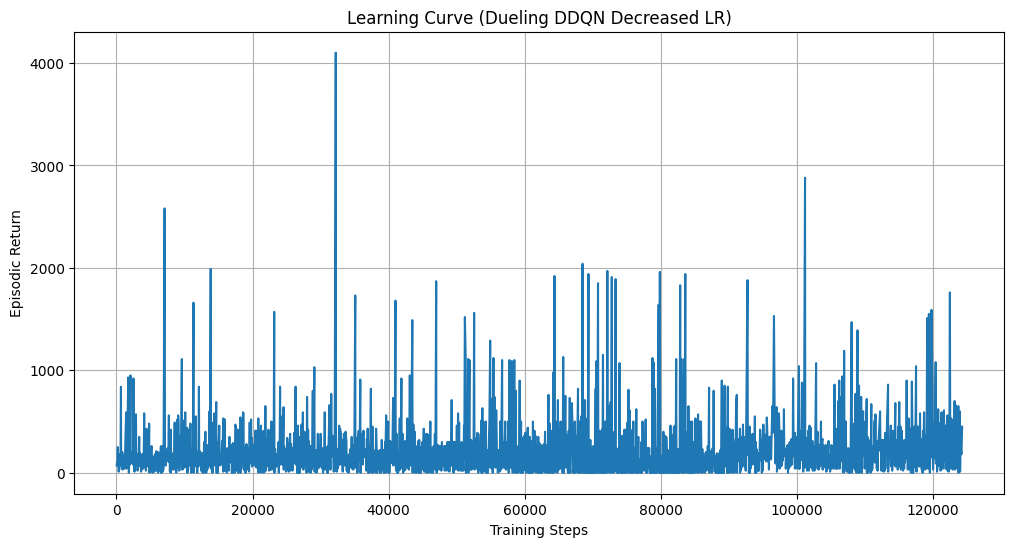

In [ ]:
import matplotlib.pyplot as plt

# Ensure episode_steps and total_rewards are available from the previous training run
# If you re-ran the training cell, these variables should be in memory.

plt.figure(figsize=(12, 6))
plt.plot(episode_steps, total_rewards)
plt.xlabel("Training Steps")
plt.ylabel("Episodic Return")
plt.title("Learning Curve (Dueling DDQN Decreased LR)")
plt.grid(True)
plt.show()

# Reflection:
Ms. Pacman represents a challenging but manageable Atari environment for studying DQN variants. Given the importance of how the rewards differ and the complex grid layout, it is a strong test domain for the improvement of a DQN, especially when the extensions chosen are given. Signs of improvement can be seen in the higher average episodic return over time, reduced variance, fewer rewards near 0, earlier learning, smoother curves (reduced overestimation), and higher asymptotic performance (better state value estimation). Some of the challenges that I faced were exploration difficulty, like early deaths and poor coverage of the maze, but Double DQN helped to reduce noisy Q-value spikes that caused greedy misbehaviors. Delayed and context-dependent rewards are an issue, especially because the game relies heavily on these state rewards, and the only way to help this is by using a Dueling DQN that provides more accurate state value representations. Overestimation of Q-values is a known issue with DQN models, so the Double DQN combats that issue by separating action selection from evaluation. High return variance was an issue for some of the testing, so a larger replay buffer helped to stabilize the results, but I did not do too much testing with that. In the future, I could continue to test the variables individually and together to find the best way to minimize all of the challenges mentioned above. Alternative epsilon decay schedules, like exponential decay, are possible. As well as adjusting the target sync to smooth Q-value drift. Including the other extension, like PER, could increase the performance in ways that I wasn’t able to see in these tests. Survival bonuses or ghost avoidance are a great way to tackle reward shaping. Sticky actions could make the environment more realistic and encourage robust policy learning. I could also change the frame stack to better capture the motion and ghost trajectories.
